In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from experiment_train import *
from experiment_datasets import *
from helpers import *
from tqdm import tqdm
import matplotlib

Using TensorFlow backend.


Initialized TensorFlow


Problem: Taylor is WAY OFF for $np>1$...

Hypothesis: need to add second term to the mean as only MEAN is off and variance is fine.
Need to calculate $L''_{ii}$, diagonal of the Hessian

In [5]:
# tf._hessian_vector_product -- use for VarDelta regularization

In [227]:
# network configuration
N = [2000, 50]

def get_p_arr(p):
    """ p array with failure on the first layer """
    return [0, p]  + [0] * len(N)

# prob. of failure at inference
p_inf = 0.01
p_inference = get_p_arr(p_inf)

# prob. of failure at train
p_trains = np.linspace(0, 1.2 * p_inf, 10)

# Lips. coeff
KLips = 1.

# activation function
activation = 'sigmoid'

# number of repeats for error estimation
# see below for explanation
repetitions = 6

# number of runs for each p
runs = 10

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 2000)              1570000   
_________________________________________________________________
dense_20 (Dense)             (None, 50)                100050    
_________________________________________________________________
dense_21 (Dense)             (None, 10)                510       
Total params: 1,670,560
Trainable params: 1,670,560
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 39us/step - loss: 58.2589 - categorical_accuracy: 0.6232 - mean_squared_error: 0.0648 - mean_absolute_error: 0.1639 - val_loss: 52.5082 - val_categorical_accuracy: 0.7929 - val_mean_squared_error: 0.0353 - val_mean_absolute_error: 0.1181
Epoch 2/10
60000/60000 [=======================

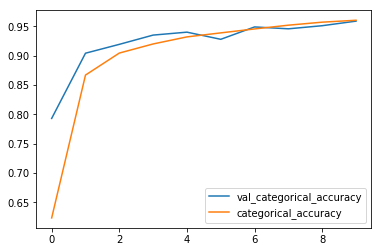

Creating network for 784-dimensional input and 10-dimensional output, with 2 hidden layers
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 2000)              1570000   
_________________________________________________________________
Crashes (Lambda)             (None, 2000)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 50)                100050    
_________________________________________________________________
dense_24 (Dense)             (None, 10)                510       
Total params: 1,670,560
Trainable params: 1,670,560
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 2000)

In [228]:
exp = MNISTExperiment(N = N, p_inference = p_inference, p_train = get_p_arr(0), KLips = KLips, epochs = 10,
                                      activation = activation, reg_type = 'balanced', reg_coeff = 1e-5, do_print = True,
                                      name = 'experiment_weights', seed = None, batch_size = 100)

In [229]:
truth = exp.y_train

In [114]:
def crashing_loss():
    prediction = exp.predict_crashing(exp.x_train, repetitions = 1)
    prediction = prediction.reshape(60000, 10)
    loss = np.mean(np.square(prediction - truth))
    return loss

In [252]:
def correct_loss():
    prediction = exp.predict_correct(exp.x_train)
    #prediction = prediction.reshape(60000, 10)
    loss = np.mean(np.square(prediction - truth))
    return loss

In [253]:
correct = correct_loss()

In [254]:
crashing = [crashing_loss() for _ in tqdm(range(50))]

In [256]:
correct * 1000

7.836443778415887

(array([ 2.,  0.,  3.,  5., 10., 15.,  7.,  6.,  1.,  1.]),
 array([8.01001588, 8.01535239, 8.0206889 , 8.02602541, 8.03136192,
        8.03669843, 8.04203494, 8.04737145, 8.05270796, 8.05804447,
        8.06338098]),
 <a list of 10 Patch objects>)

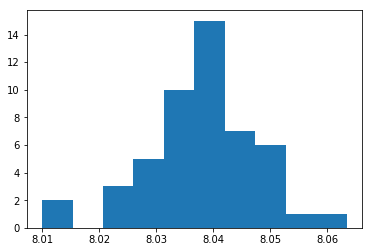

In [257]:
plt.hist(np.array(crashing) * 1000)

In [258]:
# 1. Experimental evaluation -> quite fast, doesn't ruin things much...

In [259]:
# computing probability delta of bad crash >= alpha

In [271]:
n = N[0]
t = p_inf * 3
alpha = (p_inf + t) ** 0.5
print(alpha)

0.2


In [272]:
def q_factor(array):
    """ q-balanced factor """
    array = np.abs(array)
    assert np.max(array) > 0, "Cannot compute q-factor for zero array"
        
    return np.min(array) / np.max(array)

In [273]:
q = q_factor(np.linalg.norm(exp.W[0], axis = 1) ** 2)

In [274]:
# Chernoff bound
delta = np.exp(-2*t**2*n)
delta

0.02732372244729256

In [275]:
alpha ** 2

0.04000000000000001

In [276]:
# for CHEBYSHEV
print(np.mean(crashing))
print(np.std(crashing))
a = np.std(crashing) * 3

0.008038180956124796
9.830146142664985e-06


In [320]:
# why is it negative and not equal to the experiment???
np.mean(exp._get_bound_b3_loss(exp.x_train, exp.y_train)['std'] ** 2)

6.9086245e-06

In [308]:
self = exp

In [309]:
grad = []
grad_sq = []

# list of layers
layers = self.model_correct.layers

# loss tensor
loss = self.loss

In [310]:
# TODO: speedup quadratic computation...
W = layers[0].weights[0]
S = 0.5 * p_inf * tf.reduce_sum(tf.multiply(W, tf.linalg.tensor_diag_part(tf.reshape(tf.hessians([loss], W)[0], (*W.shape, *W.shape)))))

In [311]:
sess = get_session()

In [312]:
sess.run(S, feed_dict = {exp.output_tensor: y, exp.model_correct.input: x})

ResourceExhaustedError: OOM when allocating tensor with shape[1568000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node while_11/gradients/while_11/strided_slice_grad/StridedSliceGrad (defined at <ipython-input-310-9d9c9e7c561f>:3)  = StridedSliceGrad[Index=DT_INT32, T=DT_FLOAT, begin_mask=0, ellipsis_mask=0, end_mask=0, new_axis_mask=0, shrink_axis_mask=1, _device="/job:localhost/replica:0/task:0/device:GPU:0"](while_11/gradients/while_11/strided_slice_grad/Shape, while_11/strided_slice/stack, while_11/strided_slice/stack_1, while_11/strided_slice/stack_2, while_11/gradients/Fill)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node mul_85/_639}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_385_mul_85", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'while_11/gradients/while_11/strided_slice_grad/StridedSliceGrad', defined at:
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 346, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 259, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 513, in execute_request
    user_expressions, allow_stdin,
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2817, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2843, in _run_cell
    return runner(coro)
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3018, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3183, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3265, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-310-9d9c9e7c561f>", line 3, in <module>
    S = 0.5 * p_inf * tf.reduce_sum(tf.multiply(W, tf.linalg.tensor_diag_part(tf.reshape(tf.hessians([loss], W)[0], (*W.shape, *W.shape)))))
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 1262, in hessians
    loop_vars
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py", line 3291, in while_loop
    return_same_structure)
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py", line 3004, in BuildLoop
    pred, body, original_loop_vars, loop_vars, shape_invariants)
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2939, in _BuildLoop
    body_result = body(*packed_vars_for_body)
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 1261, in <lambda>
    result.write(j, gradients(gradient[j], x)[0])),
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 630, in gradients
    gate_gradients, aggregation_method, stop_gradients)
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 814, in _GradientsHelper
    lambda: grad_fn(op, *out_grads))
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 408, in _MaybeCompile
    return grad_fn()  # Exit early
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 814, in <lambda>
    lambda: grad_fn(op, *out_grads))
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/ops/array_grad.py", line 276, in _StridedSliceGrad
    shrink_axis_mask=op.get_attr("shrink_axis_mask")), None, None, None
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 8710, in strided_slice_grad
    shrink_axis_mask=shrink_axis_mask, name=name)
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

...which was originally created as op 'while_11/strided_slice', defined at:
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 31 identical lines from previous traceback]
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 1261, in <lambda>
    result.write(j, gradients(gradient[j], x)[0])),
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 525, in _slice_helper
    name=name)
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 691, in strided_slice
    shrink_axis_mask=shrink_axis_mask)
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 8522, in strided_slice
    name=name)
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1568000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node while_11/gradients/while_11/strided_slice_grad/StridedSliceGrad (defined at <ipython-input-310-9d9c9e7c561f>:3)  = StridedSliceGrad[Index=DT_INT32, T=DT_FLOAT, begin_mask=0, ellipsis_mask=0, end_mask=0, new_axis_mask=0, shrink_axis_mask=1, _device="/job:localhost/replica:0/task:0/device:GPU:0"](while_11/gradients/while_11/strided_slice_grad/Shape, while_11/strided_slice/stack, while_11/strided_slice/stack_1, while_11/strided_slice/stack_2, while_11/gradients/Fill)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node mul_85/_639}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_385_mul_85", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [283]:
tf.gradients([loss], [layers[0].output])[0]

<tf.Tensor 'gradients_70/dense_8/MatMul_grad/MatMul:0' shape=(?, 1000) dtype=float32>

In [105]:
# w.r.t. first layer output
grad    += [tf.reduce_sum(          tf.multiply(tf.gradients([loss], [layers[0].output])[0], layers[0].output), axis = 1)]
grad_sq += [tf.reduce_sum(tf.square(tf.multiply(tf.gradients([loss], [layers[0].output])[0], layers[0].output)), axis = 1)]

In [111]:
grad_sq

[<tf.Tensor 'Sum_23:0' shape=(?,) dtype=float32>]

In [315]:
### Trying for a single object...
x = exp.x_train[0:1]
y = exp.y_train[0:1]

In [316]:
crashing = exp.predict_crashing(x, repetitions = 10000)#.reshape(1000, 10)
correct = exp.predict_correct(x)

In [317]:
np.mean(np.square(crashing - y))

0.025172659322148162

In [318]:
np.mean(np.square(correct - y))

0.024551321995098026

In [250]:
# here crashing error is bigger than correct

In [313]:
# WTF? here crashing error is less than correct...
exp._get_bound_b3_loss(x, y)['std']

array([[0.00598168]], dtype=float32)

In [314]:
# mean crashing - correct
np.mean(crashing, axis = 1) - correct

IndexError: tuple index out of range

In [245]:
exp.get_bound_b3(x)['mean']

array([[-2.9216204e-05, -5.7966111e-04,  3.7183922e-03,  4.1817925e-03,
        -3.5907721e-04, -3.0232130e-03, -2.8021978e-03,  5.3408160e-04,
        -2.0106067e-03, -8.1715413e-04]], dtype=float32)

In [246]:
y

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])